In [23]:
from sklearnex import patch_sklearn
patch_sklearn()

# import modin.pandas as pd
# import modin.numpy as np

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.utils import resample

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import time
import itertools

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 0.1 定义训练函数

In [24]:
def uniformTrain(classifier, x_train, y_train):
    start = time.time()
    classifier.fit(x_train, y_train)
    end = time.time()
    print("Training time: ", end - start)

    return classifier,(end-start)

# 0.2 定义测试函数

In [25]:
def uniformTest(classifier, x_test, y_test):

    # 预测测试集
    start_time_inference = time.time()
    y_pred = classifier.predict(x_test)
    inference_time = time.time() - start_time_inference

    # 计算F1分数和准确率
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # 输出结果
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Inference Time: {inference_time} seconds")

    return y_pred,inference_time,f1

# 0.3 定义参数搜索函数

In [26]:
def decisionTreeGS(classifier,x_train,y_train):
    param_grid = {
        # 'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        # 'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='f1')
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_

def rfGS(rf,x_train,y_train):
    param_grid = {
        # 'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        # 'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4],
        # 'criterion': ['gini', 'entropy']
    }

    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_

def svmGS(svm,x_train,y_train):
    param_grid = {
        # 'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        # 'gamma': ['scale', 'auto']
    }

    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1')
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_

def lrGS(lr,x_train,y_train):
    param_grid = {
        'max_iter': [100, 200,300]
    }

    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1')
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_

def mnbGS(mnb,x_train,y_train):
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
        'fit_prior': [True, False]
    }

    grid_search = GridSearchCV(mnb, param_grid, cv=5, scoring='f1')
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_

def knnGS(knn,x_train,y_train):
    param_grid = {

    }
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
    grid_search.fit(x_train,y_train)

    return grid_search.best_params_

def xgbGS(xgb,x_train,y_train):
    param_grid = {

    }

    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='f1')
    grid_search.fit(x_train,y_train)

    return grid_search.best_params_


# 0.4 定义数据预处理函数

In [27]:
def readData(path):
    data = pd.read_csv(path)
    return data

def preProcessData(data):
    scaler = StandardScaler()
    data['Time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))
    data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

    data = data.drop(['Time'], axis=1)
    return data

def splitData(data):
    x = data.iloc[:, 0:-1]
    y = data.iloc[:, -1]
    return x, y

def getTrainTestSet(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

def underReSample(x,y):
    sampler = RandomUnderSampler(random_state=42)
    x_resampled, y_resampled = sampler.fit_resample(x, y)
    return x_resampled, y_resampled


def overReSample(x,y):
    sampler = RandomOverSampler(random_state=42)
    x_resampled, y_resampled = sampler.fit_resample(x, y)
    return x_resampled, y_resampled

def writeData(data, path):
    data.to_csv(path, index=False)

def showClassDistribution(y):
    # 查看Class列不平衡程度
    BarNum = y.value_counts()
    BarNum.plot.bar()
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Fraud class histogram')
    plt.text(0, BarNum[0], BarNum[0], fontsize=12, horizontalalignment='center', verticalalignment='top')
    plt.text(1, BarNum[1], BarNum[1], fontsize=12, horizontalalignment='center', verticalalignment='bottom')

def showXDistribution(x):
    # 查看变量的概率密度分布
    plt.figure(figsize=(20,20))
    for i in range(0,x.shape[1]):
        plt.subplot(6, 5, i+1)
        sns.distplot(x.iloc[:,i], kde=True)

# 1. 加载和预处理数据

In [28]:
print("Loading data...")
data = readData("../dataset/creditcard.csv")
print("Preprocessing data...")
data = preProcessData(data)
# 重新采样
print("Under Resampling...")
majority_class = data[data.Class == 0]
minority_class = data[data.Class == 1]
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class)*100, random_state=42)
majority_downsampled = pd.DataFrame(majority_downsampled, columns=data.columns) 
downsampled_data = pd.concat([majority_downsampled, minority_class])
print("number of downSample data = ", len(downsampled_data))
print("Splitting data...")
x_orgin, y_orgin = splitData(data)
x, y = splitData(downsampled_data)
# x_resampled = x
# y_resampled = y
# x_resampled, y_resampled = underReSample(x, y)
# print("Over Resampling...")
# x_resampled, y_resampled = overReSample(x, y)
print("Splitting training and testing set...")
x_train, x_test, y_train, y_test = getTrainTestSet(x, y)
print("Data loaded successfully!")
print()

Loading data...
Preprocessing data...
Under Resampling...
number of downSample data =  49692
Splitting data...
Splitting training and testing set...
Data loaded successfully!



## 展示重采样后的数据集分布

/home/u206425/tmp/ipykernel_2106922/11072967.py:51: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x.iloc[:,i], kde=True)
/home/u206425/tmp/ipykernel_2106922/11072967.py:51: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x.iloc[:,i], kde=True)
/home/u206425/tmp/ipykernel_2106922/11072967.py:51: Us

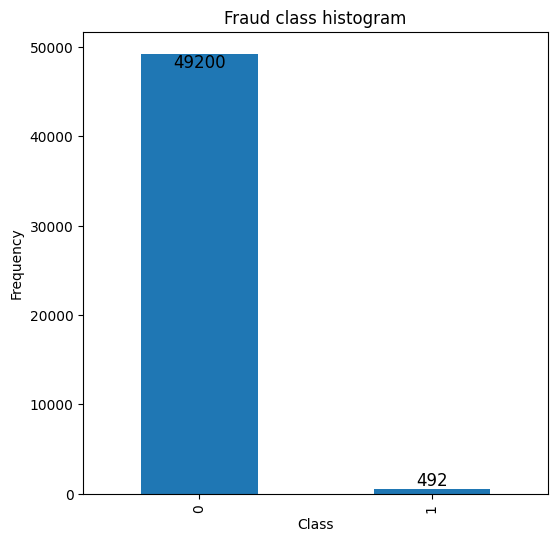

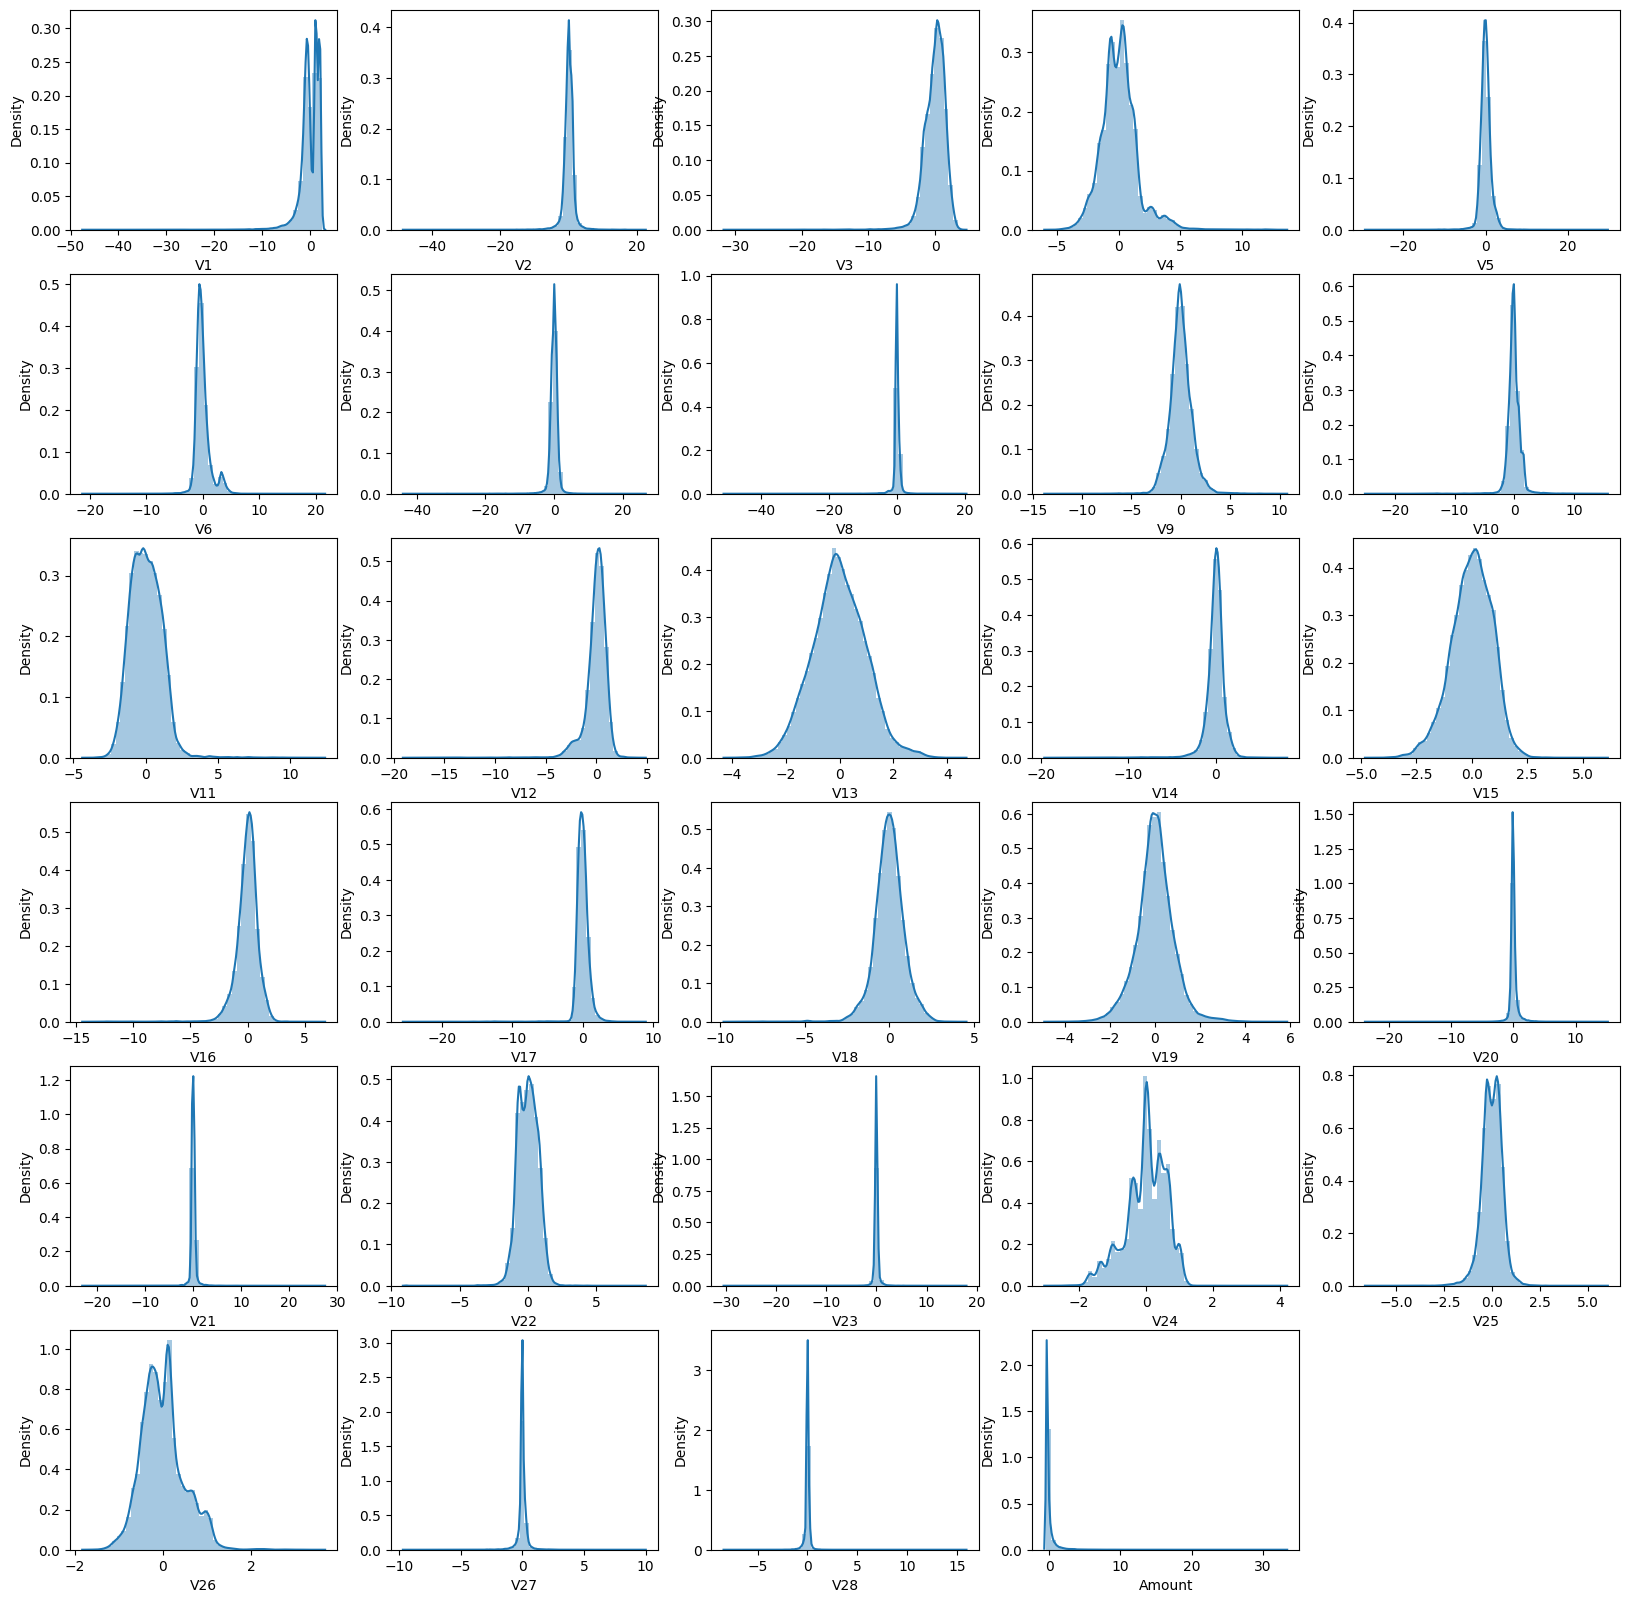

In [29]:
showClassDistribution(y)
showXDistribution(x)

# 2. 决策树

In [30]:
print("Decision Tree:")
decision_tree_params = decisionTreeGS(DecisionTreeClassifier(random_state=42), x_train, y_train)
print("Best parameters get")
decision_tree = DecisionTreeClassifier(**decision_tree_params)
decision_tree,decision_tree_time = uniformTrain(decision_tree, x_train, y_train)
print("Testing set:")
testset_dtree_pred,testset_dtree_pred_time,testset_dtree_score = uniformTest(decision_tree, x_test, y_test)
print("All set:")
dtree_pred,dtree_pred_time,dtree_score = uniformTest(decision_tree,x_orgin,y_orgin)
print()

Decision Tree:
Best parameters get
Training time:  1.6810016632080078
Testing set:
F1 Score: 0.8461538461538461
Accuracy: 0.9971828151725526
Inference Time: 0.0036728382110595703 seconds
All set:
F1 Score: 0.81524926686217
Accuracy: 0.9993363927150667
Inference Time: 0.05657219886779785 seconds



# 3. 随机森林

In [ ]:
print("Random Forest:")
rf_params = rfGS(RandomForestClassifier(random_state=42), x_train, y_train)
print("Best parameters get")
rf = RandomForestClassifier(**rf_params)
rf,rf_time = uniformTrain(rf, x_train, y_train)
print("Testing set:")
testset_rf_pred,testset_rf_pred_time,testset_rf_score = uniformTest(rf, x_test, y_test)
print("All set:")
rf_pred,rf_pred_time,rf_score = uniformTest(rf,x_orgin,y_orgin)
print()

Random Forest:


# 4. SVM

In [ ]:
print("SVM:")
svm_params = svmGS(SVC(random_state=42), x_train, y_train)
print("Best parameters get")
svm = SVC(**svm_params)
svm,svm_time = uniformTrain(svm, x_train, y_train)
print("Testing set:")
testset_svm_pred,testset_svm_pred_time,testset_svm_score = uniformTest(svm, x_test, y_test)
print("All set:")
svm_pred,svm_pred_time,svm_score = uniformTest(svm,x_orgin,y_orgin)
print()

# 5. 逻辑回归

In [ ]:
print("Logistic Regression:")
lr_params = lrGS(LogisticRegression(random_state=42), x_train, y_train)
print("Best parameters get")
lr = LogisticRegression(**lr_params)
lr,lr_time = uniformTrain(lr, x_train, y_train)
print("Testing set:")
testset_lr_pred,testset_lr_pred_time,testset_lr_score = uniformTest(lr, x_test, y_test)
print("All set:")
lr_pred,lr_pred_time,lr_score = uniformTest(lr,x_orgin,y_orgin)
print()

# 6. 朴素贝叶斯

In [ ]:
print("MultinomiaNB:")
scalar = MinMaxScaler()
x_train_NB = scalar.fit_transform(x_train)
x_test_NB = scalar.fit_transform(x_test)
mnb_params = mnbGS(MultinomialNB(), x_train_NB, y_train)
print("Best parameters get")
mnb = MultinomialNB(**mnb_params)
mnb,mnb_time = uniformTrain(mnb, x_train_NB, y_train)
print("Testing set:")
testset_mnb_pred,testset_mnb_pred_time,testset_mnb_score = uniformTest(mnb, x_test_NB, y_test)
print("All set:")
mnb_pred,mnb_pred_time,mnb_score = uniformTest(mnb,scalar.fit_transform(x_orgin),y_orgin)
print()

# 7. KNN

In [ ]:
print("KNN:")
knn_params = knnGS(KNeighborsClassifier(), x_train, y_train)
print("Best parameters get")
knn = KNeighborsClassifier(**knn_params)
knn,knn_time = uniformTrain(knn, x_train, y_train)
print("Testing set:")
testset_knn_pred,testset_knn_pred_time,testset_knn_score = uniformTest(knn, np.array(x_test), y_test)
print("All set:")
knn_pred,knn_pred_time,knn_score = uniformTest(knn,np.array(x_orgin),y_orgin)
print()

# 8. xgboost

In [ ]:
print("xgboost:")
xgb_params = xgbGS(XGBClassifier(random_state=42), x_train, y_train)
print("Best parameters get")
xgb = XGBClassifier(**xgb_params)
xgb,xgb_time = uniformTrain(xgb, x_train, y_train)
print("Testing set:")
testset_xgb_pred,testset_xgb_pred_time,testset_xgb_score = uniformTest(xgb, x_test, y_test)
print("All set:")
xgb_pred,xgb_pred_time,xgb_score = uniformTest(xgb,x_orgin,y_orgin)
print()

# 9. 使用混淆矩阵观察

In [ ]:
def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix for the models

tree_matrix = confusion_matrix(y_orgin, dtree_pred, 
                labels = [0, 1]) # Decision Tree
rf_matrix = confusion_matrix(y_orgin, rf_pred, 
                labels = [0, 1]) # Random Forest Tree
svm_matrix = confusion_matrix(y_orgin, svm_pred, 
                labels = [0, 1]) # Support Vector Machine
lr_matrix = confusion_matrix(y_orgin, lr_pred, 
                labels = [0, 1]) # Logistic Regression
knn_matrix = confusion_matrix(y_orgin, 
                knn_pred, labels = [0, 1]) # K-Nearest Neighbors
mnb_matrix = confusion_matrix(y_orgin,
                mnb_pred, labels = [0, 1]) # Multinomial Naive Bayes
xgb_matrix = confusion_matrix(y_orgin, xgb_pred, 
                labels = [0, 1]) # XGBoost

# Plot the confusion matrix
plt.rcParams['figure.figsize'] = (6, 6)

In [ ]:
# 绘制混淆矩阵
tree_cm_plot = plot_confusion_matrix(tree_matrix, 
                      classes = ['Non-Default(0)','Default(1)'], 
                      normalize = False, title = 'Decision Tree')
plt.savefig('tree_cm_plot.png')
plt.show()

rf_cm_plot = plot_confusion_matrix(rf_matrix,
                    classes = ['Non-Default(0)','Default(1)'], 
                    normalize = False, title = 'Random Forest')
plt.savefig('rf_cm_plot.png')
plt.show()

svm_cm_plot = plot_confusion_matrix(svm_matrix,
                    classes = ['Non-Default(0)','Default(1)'], 
                    normalize = False, title = 'Support Vector Machine')
plt.savefig('svm_cm_plot.png')
plt.show()

lr_cm_plot = plot_confusion_matrix(lr_matrix,
                    classes = ['Non-Default(0)','Default(1)'], 
                    normalize = False, title = 'Logistic Regression')
plt.savefig('lr_cm_plot.png')
plt.show()

knn_cm_plot = plot_confusion_matrix(knn_matrix,
                    classes = ['Non-Default(0)','Default(1)'], 
                    normalize = False, title = 'K-Nearest Neighbors')

plt.savefig('knn_cm_plot.png')
plt.show()

mnb_cm_plot = plot_confusion_matrix(mnb_matrix,
                    classes = ['Non-Default(0)','Default(1)'], 
                    normalize = False, title = 'Multinomial Naive Bayes')
plt.savefig('mnb_cm_plot.png')
plt.show()

xgb_cm_plot = plot_confusion_matrix(xgb_matrix,
                    classes = ['Non-Default(0)','Default(1)'], 
                    normalize = False, title = 'XGBoost')
plt.savefig('xgb_cm_plot.png')
plt.show()

# 10. 使用ROC曲线进行观察

In [ ]:
# ROC曲线
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid(True)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')

tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_orgin, dtree_pred)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_orgin, rf_pred)
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_orgin, svm_pred)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_orgin, lr_pred)
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_orgin, knn_pred)
mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(y_orgin, mnb_pred)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_orgin, xgb_pred)

plt.figure(figsize = (8, 6))
plot_roc_curve(tree_fpr, tree_tpr, label = 'Decision Tree')
plot_roc_curve(rf_fpr, rf_tpr, label = 'Random Forest')
plot_roc_curve(svm_fpr, svm_tpr, label = 'Support Vector Machine')
plot_roc_curve(lr_fpr, lr_tpr, label = 'Logistic Regression')
plot_roc_curve(knn_fpr, knn_tpr, label = 'K-Nearest Neighbors')
plot_roc_curve(mnb_fpr, mnb_tpr, label = 'Multinomial Naive Bayes')
plot_roc_curve(xgb_fpr, xgb_tpr, label = 'XGBoost')

plt.legend()
plt.savefig('roc_curve.png')
plt.show()

# 11. 不同模型效果图形化比较

In [ ]:
# 在构造出的测试集上的f1 score
f1s_allset = [testset_dtree_score,testset_rf_score,testset_svm_score,testset_lr_score,testset_mnb_score,testset_knn_score,testset_xgb_score]
x_values = ['Decision Tree','Random Forest','SVM','Logistic Regression','MultinomiaNB','KNN','xgboost']

# 绘制折线
plt.plot(x_values, f1s_allset, label='F1 Score', marker='o')

# 添加标题和标签
plt.title('F1 Score Over Testset')
plt.xlabel('Model')
plt.ylabel('F1 Score')

# 添加图例
plt.legend()
plt.savefig('f1_score_over_testset.png')
# 显示图形
plt.show()

In [ ]:
# 在原有完整数据集上的f1 score
f1s_allset = [dtree_score,rf_score,svm_score,lr_score,mnb_score,knn_score,xgb_score]
x_values = ['Decision Tree','Random Forest','SVM','Logistic Regression','MultinomiaNB','KNN','xgboost']

# 绘制折线
plt.plot(x_values, f1s_allset, label='F1 Score', marker='o')

# 添加标题和标签
plt.title('F1 Score Over Origin Dataset')
plt.xlabel('Model')
plt.ylabel('F1 Score')

# 添加图例
plt.legend()
plt.savefig('f1_score_over_origin_dataset.png')
# 显示图形
plt.show()

In [ ]:
# 训练时间表现
train_times = [decision_tree_time,rf_time,svm_time,lr_time,mnb_time,knn_time,xgb_time]
x_values = ['Decision Tree','Random Forest','SVM','Logistic Regression','MultinomiaNB','KNN','xgboost']

# 绘制折线
plt.plot(x_values, train_times, label='Time', marker='o')

# 添加标题和标签
plt.title('Training Time')
plt.xlabel('Model')
plt.ylabel('Time')

# 添加图例
plt.legend()
# plt.savefig('training_time.png')
plt.savefig('intel_training_time.png')
# 显示图形
plt.show()

In [ ]:
# 在测试集上的预测时间
pred_times = [testset_dtree_pred_time,testset_rf_pred_time,testset_svm_pred_time,testset_lr_pred_time,testset_mnb_pred_time,testset_knn_pred_time,testset_xgb_pred_time]
x_values = ['Decision Tree','Random Forest','SVM','Logistic Regression','MultinomiaNB','KNN','xgboost']

# 绘制折线
plt.plot(x_values, pred_times, label='Time', marker='o')

# 添加标题和标签
plt.title('Prediction Time Over Testset')
plt.xlabel('Model')
plt.ylabel('Time')

# 添加图例
plt.legend()
# plt.savefig('prediction_time_over_testset.png')
plt.savefig('intel_prediction_time_over_testset.png')
# 显示图形
plt.show()

In [ ]:
# 在原有完整数据集上的预测时间
pred_times = [dtree_pred_time,rf_pred_time,svm_pred_time,lr_pred_time,mnb_pred_time,knn_pred_time,xgb_pred_time]
x_values = ['Decision Tree','Random Forest','SVM','Logistic Regression','MultinomiaNB','KNN','xgboost']

# 绘制折线
plt.plot(x_values, pred_times, label='Time', marker='o')

# 添加标题和标签
plt.title('Prediction Time Over Origin Dataset')
plt.xlabel('Model')
plt.ylabel('Time')

# 添加图例
plt.legend()
# plt.savefig('prediction_time_over_origin_dataset.png')
plt.savefig('intel_prediction_time_over_origin_dataset.png')
# 显示图形
plt.show()